This notebook reads the 'singlerun.txt' output file which contains elastic interactions positions and produces a number of distribution plots.

Let's import some libraries:

In [140]:
import numpy as np                     # the usual numpy

In [141]:
import plotly.offline as offline       # a number of plotly goodies
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [142]:
import matplotlib as mlab
import matplotlib.pyplot as plt        # some matplotlib for good measure
from matplotlib.colors import LogNorm

In [143]:
import scipy.stats as st               # and scipy in case everything else fails
from scipy import interpolate
from scipy.interpolate import griddata

### Test the random number generator

In [144]:
randomnumber = 'outtestran.txt'

In [145]:
rNumber = []
with open(randomnumber, "r") as data:
    for line in data: #read one line at a time
        data = line.split()
        rNumber.append(float(data[0]))

In [146]:
bin1 = [i for i in rNumber if i <= 0.1]

In [147]:
traceH = go.Histogram(
    x = rNumber,
    name = 'Random number',
    #histnorm = 'probability',
    #autobinx = True,
    xbins = dict(
            start=0,
            end=1,
            size=0.01
        ),
    marker = dict(color='#2d1e3e'),
    xaxis = 'x2'
)

fig = go.Figure(data=[traceH])

py.iplot(fig, filename='random number')

In [148]:
firstStep = 'firstStep.dat'

In [149]:
firstStepdata = []
with open(firstStep, "r") as data:
    for line in data: #read one line at a time
        data = line.split()
        firstStepdata.append(float(data[0]))

IndexError: list index out of range

In [ ]:
traceH = go.Histogram(
    x = firstStepdata,
    name = 'Random number',
    histnorm = 'probability',
    autobinx = True,
    #xbins = dict(
    #        start=0,
    #        end=1,
    #        size=0.1
    #    ),
    marker = dict(color='#2d1e3e'),
    xaxis = 'x2'
)

fig = go.Figure(data=[traceH])

py.iplot(fig, filename='random number')

Use the data file:

In [150]:
fileName = 'singlerun.txt'

Before we read the datafile and create lists of data we have to initialise a bunch of parameters:

In [207]:
el = -1        #electon identifier
step = 0       #step number
energy = []    #energy array of electron el
energy.append([])
xyz = []       # xyz positions array for electron el
xyz.append([])
cxyz = []      # directional cosines array for electron el
cxyz.append([])
dEdS = []

Read all file and store all xyz positions for each electron. one electron data is in between lines with first column containing " 0: "

In [214]:
with open(fileName, "r") as data:
    for line in data: #read one line at a time
        column = line.replace(':',' ').replace(',',' ').split()


        if column[0] is '0': #reinitialise and update
            energy.append([])
            cxyz.append([])
            xyz.append([])

            el = el + 1

        energy[el].append(float(column[1]))
        cxyz[el].append([ float(column[2]), float(column[3]), float(column[4]) ])
        xyz[el].append([ float(column[5]), float(column[6]), float(column[7]) ])
        if len(column)>8:
            dEdS.append(float(column[8]))


Initialise the backscattered electrons sum:

In [153]:
BSE2 = 0       # this is a type 2 signal

Initialise more lists:

In [154]:
b_energy = [] #energy array of backscattered electron el
b_energy.append([])
b_xyz = []    #xyz position array for backscattered electron el
b_xyz.append([])
b_cxyz = []   #directional cosines array for backscattered electron el
b_cxyz.append([])


In [155]:
for i in range(el+1):

    zs = [positions[2] for positions in xyz[i] ] # z values

    if any( z > 0 for z in zs): #backattered
        b_energy[BSE2] = energy[i]
        b_cxyz[BSE2] = cxyz[i]
        b_xyz[BSE2] = xyz[i]

        BSE2 = BSE2 + 1
        b_energy.append([])
        b_xyz.append([])
        b_cxyz.append([])


The number of backscattered electrons is:

In [156]:
BSE2

5217

Which is hard to work with so I'm making every parameter a long array.

In [157]:
b_xs = [] # list of basckattered electrons x positions
b_zs = []

for traj in b_xyz:
    for event in traj:
        b_xs.append(event[0])
        b_zs.append(event[2])

        
b_czs = [] # list of directional cosines 
for traj in b_cxyz:
    for event in traj:
        b_czs.append(event[2])
    
    
b_energy_ar = np.array([item for sublist in b_energy for item in sublist])
b_xs_ar = np.array(b_xs)
b_zs_ar = np.array(b_zs)
b_czs_ar = np.array(b_czs)

# Remove z values > 0 
inside_indxs = np.where(b_zs_ar<0)
outside_indxs = np.where(b_zs_ar>0)
last_indxs = outside_indxs[0] - 1
b_xs_ar_in = b_xs_ar[inside_indxs]
b_zs_ar_in = b_zs_ar[inside_indxs]
b_energy_ar_in = b_energy_ar[inside_indxs]
b_czs_ar_in = b_czs_ar[inside_indxs]

b_lastzs_ar = b_zs_ar[last_indxs]
b_lastczs_ar = b_czs_ar[last_indxs]
b_lastenergy_ar =  b_energy_ar[last_indxs]

print b_lastzs_ar[:]
print b_lastczs_ar[b_lastzs_ar<-800]
print b_lastenergy_ar[b_lastzs_ar<-800]

[ -3.3485  -2.2689  -3.9191 ..., -18.898   -3.8851  -5.6495]
[]
[]


Let us inquire about the energy lost from the last elastic event to exit

### Last elastic events

In [158]:
last_d = np.abs(b_lastzs_ar[b_lastczs_ar>0.3]/b_lastczs_ar[b_lastczs_ar>0.3])

traceScatter = go.Scatter(
    x = b_lastenergy_ar[b_lastczs_ar>0.3],
    #y = last_d,
    y = b_lastzs_ar[b_lastczs_ar>0.3],
    mode = 'markers',
    name = 'events',
    marker = dict(
        color='#2d1e3e',
        size = 6,
        #size = weight_escape_b[:1000]*0.1,
        opacity=0.4
    )
)


data = [traceScatter]

layout = go.Layout(
    xaxis=dict(
        title='Energy (keV)'
    ),
    yaxis=dict(
        title='exit distance (A)'
    ))


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='last event')

elena's purple colors:

In [159]:
purples=[[0.0,   '#fcf9f7'],
 [0.1666666666666666, '#edcfc9'],
 [0.3333333333333333, '#daa2ac'],
 [0.5,                '#bc7897'],
 [0.6666666666666666, '#925684'],
 [0.8333333333333333, '#5f3868'],
 [1.0,                '#2d1e3e']]

### Decide how big an image:###

In [180]:
x1, x2 = (10, 20)
y1, y2 = (-50, 0)

### Define a 2D KDE function to show a heat map ###

In [181]:
def kde_scipy( vals1, vals2, (a,b), (c,d), N, bw ):

    #vals1, vals2 are the values of two variables (columns)
    #(a,b) interval for vals1; usually larger than (np.min(vals1), np.max(vals1))
    #(c,d) -"-          vals2

    x = np.linspace(a,b,N)
    y = np.linspace(c,d,N)
    X,Y = np.meshgrid(x,y)
    positions = np.vstack([Y.ravel(), X.ravel()])

    values = np.vstack([vals1, vals2])
    kernel = st.gaussian_kde(values, bw_method = bw)
    Z = np.reshape(kernel(positions).T, X.shape)

    return [x, y, Z]


def make_kdedata(varX, varY, (a,b), (c,d), N, bw, colorsc):
    #varX, varY are lists, 1d numpy.array(s), or dataframe columns, storing the values of two variables

    x, y, Z = kde_scipy(varY, varX, (a,b), (c,d), N, bw )

    data = go.Data([
       go.Contour(
           z=Z,
           x=x,
           y=y,
           colorscale=colorsc,
           #reversescale=True,
           opacity=0.9,
           contours=go.Contours(
               showlines=False)
        ),
     ])
    
    return data

In [201]:
x1E, x2E = (10, 20)
y1E, y2E = (-50, 0)
N = 200 # point to sample on a mesh for the KDE
bw = 0.3 # bandwidth
KDEdata = make_kdedata(b_lastenergy_ar[b_lastczs_ar>0.0], b_lastzs_ar[b_lastczs_ar>0.0], (x1, x2), (y1, y2), N, bw, purples)

layoutKDE =  go.Layout(xaxis = dict(title = 'Energy (keV)'), 
                    yaxis = dict(title = 'exit Z (nm)'),
                    title = 'Uniformly sampled KDE')
figureKDE = go.Figure(data=KDEdata, layout= layoutKDE)

py.iplot(figureKDE)

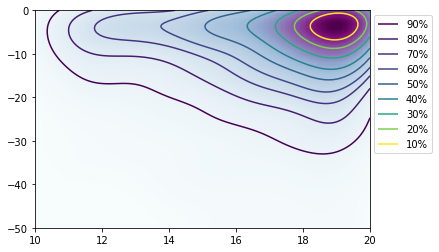

In [202]:
xKDE, yKDE, ZKDE = kde_scipy(b_lastzs_ar[b_lastczs_ar>0.0],b_lastenergy_ar[b_lastczs_ar>0.0], (x1,x2), (y1,y2), N, bw )
ZKDE = ZKDE / ZKDE.sum()

n = 100
t = np.linspace(0, ZKDE.max(), n)
integral = ((ZKDE >= t[:, None, None]) * ZKDE).sum(axis=(1,2))


f = interpolate.interp1d(integral, t)
t_contours = f(np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]))
plt.imshow(ZKDE, origin='lower', extent=[x1, x2, y1, y2], cmap="BuPu", aspect='auto')
CS = plt.contour(ZKDE, t_contours, extent=[x1, x2, y1, y2])

labels = ['90%', '80%','70%','60%', '50%', '40%', '30%', '20%', '10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
plt.legend(bbox_to_anchor=(1.2, 1.))
plt.show()

##### This looks a lot like figure 7b in Patrick's paper

#### Next choose only last elastic angles greater than 60 degrees (acos(0.5)) -- electron existing with at least a grazing angle of 10 degrees after the first incidence

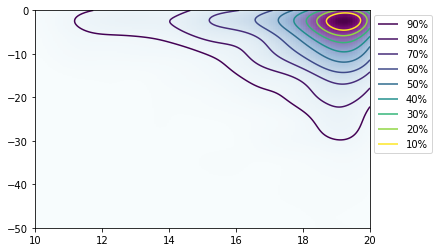

In [205]:
xKDE, yKDE, ZKDE = kde_scipy(b_lastzs_ar[b_lastczs_ar<0.5],b_lastenergy_ar[b_lastczs_ar<0.5], (x1,x2), (y1,y2), N, bw )
ZKDE = ZKDE / ZKDE.sum()

n = 200
t = np.linspace(0, ZKDE.max(), n)
integral = ((ZKDE >= t[:, None, None]) * ZKDE).sum(axis=(1,2))


f = interpolate.interp1d(integral, t)
t_contours = f(np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]))
plt.imshow(ZKDE, origin='lower', extent=[x1, x2, y1, y2], cmap="BuPu", aspect='auto')
CS = plt.contour(ZKDE, t_contours, extent=[x1, x2, y1, y2])

labels = ['90%', '80%','70%','60%', '50%', '40%', '30%', '20%', '10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
plt.legend(bbox_to_anchor=(1.2, 1.))
plt.show()

More likely for higher energy electrons to exit through a large angle scattering.

If data is too large of an array we'll do some sampling.

### For the next magic trick let us look at the stopping power of the electrons on their way out 

#### How much energy did the electrons loose since the incoherent event until they reach the detector

#### Function to sample $n$ points with probabilities $p$ from a large array $a$:

In [215]:

def uniform_sample(nu, au):
    # numpy.random.choice(a, size=None, replace=True, p=None)
    return np.random.choice(au, size=nu, replace=True)



def nonuniform_sample(nn, an, p):
    return np.random.choice(an, size=nn, replace=True, p=p)



### Make a scatter plot ###

Let's only sample 5000 points for fast plotting

In [216]:
num = 5000
# sample from the indexes
sample_idxs = uniform_sample(num,len(b_xs_ar))

b_sample_xs = b_xs_ar[sample_idxs]
b_sample_zs = b_zs_ar[sample_idxs]
b_sample_energy = b_energy_ar[sample_idxs]
print len(b_xs_ar)

446415


In [232]:
x1, x2 = (-20, 3000)
y1, y2 = (-1000, 0)

traceScatter = go.Scatter(
    x = b_sample_xs,
    y = b_sample_zs,
    mode = 'markers',
    name = 'events',
    marker = dict(
        color='#2d1e3e',
        size = 4,
        #size = weight_escape_b[:1000]*0.1,
        opacity=0.4
    )
)

### Histogram of probabilities of finding an electron at depth z which will plot on the right hand side of the image

In [233]:
traceHside = go.Histogram(
    y = b_sample_zs,
    name = 'z density',
    histnorm = 'probability',
    autobinx = True,
    #ybins = dict(
    #        start=zmax,
    #        end=0,
    #        size=50
    #    ),
    marker = dict(color='#2d1e3e'),
    xaxis = 'x2'
)


### Build Layout ###

In [234]:


layoutSandH = go.Layout(
    showlegend=False,
    autosize=False,
    width=880,
    height=650,

    xaxis=dict(go.XAxis(range=[x1, x2]),
               domain=[0, 0.81],
               nticks=5,
               showgrid=False,
               zeroline=False,
               title='x Axis (nm)',
               titlefont=dict(
               family='Courier New, monospace',
               size=20,
               color='#7f7f7f')
        ),
    yaxis=dict(go.YAxis(range=[y1,y2]),
               domain=[0, 1],
               nticks=5,
               showgrid=False,
               zeroline=False,
               title='z Axis (nm)',
               titlefont=dict(
               family='Courier New, monospace',
               size=20,
               color='#7f7f7f')
    ),

    margin=dict(
             t=50
    ),

    hovermode='closest',
    bargap=0,
    xaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    ),
    #title='Elastic events scatter plot',
    #paper_bgcolor='rgba(0,0,0,0)',
    #plot_bgcolor='rgba(0,0,0,0)'
)

In [235]:
dataToPlot = [ traceScatter, traceHside]
figSandH = go.Figure(data=dataToPlot, layout=layoutSandH)

And  plot:

In [236]:
py.iplot(figSandH)

A closer look at the depth density histogram:

In [237]:
figDepth = ff.create_distplot([ b_sample_zs], ['depth density'],  bin_size=200 )
py.iplot(figDepth, filename = 'Backscattered electrons Depth Distribution Unweighted' )


And KDE plot:

In [238]:
N = 200 # point to sample on a mesh for the KDE
bw = 0.2 # bandwidth
KDEdata = make_kdedata(b_sample_xs, b_sample_zs, (x1, x2), (y1, y2), N, bw, purples)

layoutKDE =  go.Layout(xaxis = dict(title = 'X axis (nm)'), 
                    yaxis = dict(title = 'Z axis (nm)'),
                    title = 'Uniformly sampled KDE')
figureKDE = go.Figure(data=KDEdata, layout= layoutKDE)

py.iplot(figureKDE)

### Probabilistic sampling

This is a representation of the spatial distribution predicted by Monte Carlo. If I want to sample this distribution I cannot use a uniform sampling grid, I ought to sample more from higher densities and less from lower densities. Such that a $RND = \int_a ^x P(x)dx$ gives the value of x. Here P(x) can be numerically derived from the KDE.

Below I'm showing contour plots for probabilities of finding an electron inside a given contour.
The calculation of contour probabilities requires the computations of integrals inside the contour p(x) ≥ t.

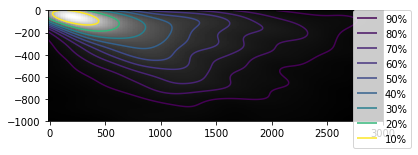

In [239]:
xKDE, yKDE, ZKDE = kde_scipy(b_sample_zs, b_sample_xs, (x1,x2), (y1,y2), N, bw )
ZKDE = ZKDE / ZKDE.sum()

n = 100
t = np.linspace(0, ZKDE.max(), n)
integral = ((ZKDE >= t[:, None, None]) * ZKDE).sum(axis=(1,2))



f = interpolate.interp1d(integral, t)
t_contours = f(np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]))
plt.imshow(ZKDE, origin='lower', extent=[x1, x2, y1, y2], cmap="gray")
CS = plt.contour(ZKDE, t_contours, extent=[x1, x2, y1, y2])

labels = ['90%', '80%','70%','60%', '50%', '40%', '30%', '20%', '10%']
for i in range(len(labels)):
    CS.collections[i].set_label(labels[i])
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [240]:
xz_sample = np.array([(a,b) for a, b in zip(*(b_sample_xs, b_sample_zs))])
inCont = np.zeros((9, num))

for line in range(8):
    p = CS.collections[line].get_paths()[0]
    x = p.vertices[:,0]
    z = p.vertices[:,1]
    XZ = np.array([(a,b) for a, b in zip(*(x, z))])

    contour = mlab.path.Path(XZ)
    inCont[line] = contour.contains_points(xz_sample)
    
p_weights = [sum([yesno[point] for yesno in inCont]) for point in range(num)]

In [241]:
sum_pweights = sum(p_weights)
b_weight_p = p_weights/sum_pweights # normalise this array to probabilities

n_p = 5000
Psample_indxs = nonuniform_sample(n_p , len(b_sample_xs), b_weight_p)

b_NUsample_x = b_sample_xs[Psample_indxs]
b_NUsample_z = b_sample_zs[Psample_indxs]
b_NUsample_energy = b_sample_energy[Psample_indxs]

In [242]:
figDepth = ff.create_distplot([b_NUsample_z], ['depth probability of incoherent scattering'],  bin_size=100 )
py.iplot(figDepth, filename = 'Frequency of incoherent scattering with depth' )

In [243]:

traceScatter = go.Scatter(
    x = b_NUsample_x,
    y = b_NUsample_z,
    mode = 'markers',
    name = 'events',
    marker = dict(
        color='#2d1e3e',
        size = 2,
        #size = point_size*2.1,
        opacity=0.4
    )
)

traceHside = go.Histogram(
    y=b_NUsample_z,
    name = 'z density',
    histnorm = 'probability',
    autobinx = True,
    #ybins = dict(
    #        start=zmax,
    #        end=0,
    #        size=50
    #    ),
    marker = dict(color='#2d1e3e'),
    xaxis = 'x2'
)


dataToPlot = [ traceScatter, traceHside]
figSandH = go.Figure(data=dataToPlot, layout=layoutSandH)
py.iplot(figSandH)

In [244]:
N = 200 # point to sample on a mesh for the KDE
bw = 0.2 # bandwidth
KDEdata = make_kdedata(b_NUsample_x, b_NUsample_z, (x1, x2), (y1, y2), N, bw, purples)
traceKDE = go.Figure(data=KDEdata)

py.iplot(KDEdata)

# Probability of incohernet scattering at a depth z

### Weight events for how far the electron traveled before the event

The probability of producing an incoherent scattering event ought to increase with the distance travelled in the material.

To account for this I'm going to use the loss of energy until that event since the stopping power dictating the loss of energy is almost constant (i.e. independent on energy) in the energy range used in the SEM.

[TODO] come back to check this or use actual distances

Should also sample proportionally with energy to avoid outliers dominating.

In [245]:
#cut_off = 15.

sum_Eweights = sum(b_NUsample_energy)
b_weight_E = b_NUsample_energy/sum_Eweights # normalise this array to probabilities

n_E = 5000
Esample_indxs = nonuniform_sample(n_E , len(b_NUsample_x), b_weight_E)

b_NUsampleE_x = b_NUsample_x[Psample_indxs]
b_NUsampleE_z = b_NUsample_z[Psample_indxs]
b_NUsampleE_energy = b_NUsample_energy[Psample_indxs]




#b_NUsampleE_energy = b_NUsample_energy[np.where(b_NUsample_energy>cut_off)]
#b_NUsampleE_x = b_NUsample_x[np.where(b_NUsample_energy>cut_off)]
#b_NUsampleE_z = b_NUsample_z[np.where(b_NUsample_energy>cut_off)]



In [246]:
DistanceHistogram = [go.Histogram(x=20.-b_NUsampleE_energy,
                     histnorm='probability')]

layout = go.Layout(
    xaxis=dict(
        title='energy lost (keV)'
    ),
    yaxis=dict(
        title='Normalised frequency'
    ))
    
fig = go.Figure(data=DistanceHistogram, layout=layout)
py.iplot(fig, filename='normalized histogram')

In [247]:
figDepth = ff.create_distplot([b_NUsampleE_z], ['depth probability of incoherent scattering'],  bin_size=100 )
py.iplot(figDepth, filename = 'Frequency of incoherent scattering with depth' )

Plot the distance traveled weighting

In [248]:
trace = go.Scatter(
    x = 20.-b_NUsampleE_energy,
    y = (20.-b_NUsampleE_energy), 
    mode = 'line'
)

data = [trace]

layout = go.Layout(
    xaxis=dict(
        title='distance traveled (a.u.)'
    ),
    yaxis=dict(
        title='Weight value (a.u.)'
    ))


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='distance weighting')

I'm going to approximate the probability of incoherent scattering occuring at a depth z in the sample as the entire depth distribution of electrons weighted by a probability of incoherent scattering which to a first approximation is given by a linear dependence on how long did the electron traveled until that point. 

In [249]:
lost_energies = 20.-  np.array(b_NUsampleE_energy)
sum_energies = sum(lost_energies)
b_weight_z = lost_energies/ sum_energies # normalise this array to probabilities

n = 6000
Ssample_indxs = nonuniform_sample(n , len(b_NUsampleE_z), b_weight_z)

b_Ssample_z = b_NUsampleE_z[Ssample_indxs]
b_Ssample_x = b_NUsampleE_x[Ssample_indxs]
b_Ssample_energy = b_NUsampleE_energy[Ssample_indxs]

point_size = lost_energies[Ssample_indxs] # for scatter plot

In [250]:
figDepth = ff.create_distplot([b_Ssample_z], ['depth probability of incoherent scattering'],  bin_size=100 )
py.iplot(figDepth, filename = 'Frequency of incoherent scattering with depth' )

In [66]:
traceScatter = go.Scatter(
    x = b_Ssample_x,
    y = b_Ssample_z,
    mode = 'markers',
    name = 'events',
    marker = dict(
        color='#2d1e3e',
        #size = 2,
        size = point_size*2.1,
        opacity=0.4
    )
)

traceHside = go.Histogram(
    y=b_Ssample_z,
    name = 'z density',
    histnorm = 'probability',
    autobinx = True,
    #ybins = dict(
    #        start=zmax,
    #        end=0,
    #        size=50
    #    ),
    marker = dict(color='#2d1e3e'),
    xaxis = 'x2'
)


dataToPlot = [ traceScatter, traceHside]
figSandH = go.Figure(data=dataToPlot, layout=layoutSandH)
py.iplot(figSandH)

In [65]:
N = 100
bw = 0.4
KDEdata = make_kdedata(b_Ssample_x, b_Ssample_z, (0, 20000), (-8000, 0), N, bw, purples)
py.iplot(KDEdata)

# Probability for an incoherent electron to reach the detector

### Is given by how far from the exiting surface the event is
##### This can also be seen as taking into account a possible mean free path for information conservation; i.e. how far is an incoherently scattered electron likely to travel before it looses diffraction information. I'm giving this an exponential form rather than linear, similarly to the form of the absorbed elctron wave in the Howie-Whelan equations.

$P(z) = exp(-z/zmax)$

In [251]:
# let zmax be depth in which 90% of electrons are
maxInfoDepth = np.percentile(-b_Ssample_z,80)
print maxInfoDepth

b_escape= np.exp(b_Ssample_z*2./maxInfoDepth)
sum_escape = sum(b_escape)
b_weight_escape = b_escape/ sum_escape # normalise this array to probabilities


n = 5000
Isample_indxs = nonuniform_sample(n, len(b_Ssample_z), b_weight_escape)

b_Isample_z = b_Ssample_z[Isample_indxs]
b_Isample_x = b_Ssample_x[Isample_indxs]
b_Isample_energy = b_Ssample_energy[Isample_indxs]



389.14886


In [75]:
trace = go.Scatter(
    x = b_Isample_z,
    y = b_weight_escape[Isample_indxs],  
    mode = 'markers'
)

data = [trace]

layout = go.Layout(
    xaxis=dict(
        title='Z axis', 
        #range = [-6000, 0]
    ),
    yaxis=dict(
        title='Escape probability weight',          
        #range = [0, 0.0004]

    ))


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='escape chance weighting')

In [76]:
figDepth = ff.create_distplot([b_Isample_z], ['escaped electrons depth'], bin_size= 100 )
py.iplot(figDepth, filename = 'Depth distribution of information' )

In [78]:
figEnergy = ff.create_distplot([b_Isample_energy], ['escaped electrons energy'], bin_size= 0.2)
py.iplot(figEnergy, filename = 'Energy distribution of information' )


In [82]:
N = 100
bw = 0.4
KDEdata = make_kdedata(b_Isample_x, b_Isample_z, (0, 20000), (-8000, 0), N, bw, purples)
layoutKDE =  go.Layout(title = 'Information depth distribution')
figure = go.Figure(data = KDEdata, layout = layoutKDE)
py.iplot(figure, filename = 'information depth')

In [83]:
trace = go.Scatter (x = b_Isample_energy, y = -b_Isample_z,mode = 'markers' )

data = [trace]
layout =  go.Layout(xaxis = dict(title = 'Energy (keV)'), 
                    yaxis = dict(title = 'Escape depth (nm)'),
                    title = 'Exit distance versus energy')
fig = go.Figure(data=data, layout = layout)
py.iplot(fig, filename='exit distance versus energy')

In [84]:
b_hist_E, b_bins_E = np.histogram(b_Isample_energy, bins = 5)


b_bin_start = b_bins_E[-2]
b_bin_end = b_bins_E[-1]
b_ebin1_z = b_Isample_z[np.where((b_Isample_energy>=b_bin_start) & (b_Isample_energy<b_bin_end))]

b_bin_start = b_bins_E[-3]
b_bin_end = b_bins_E[-2]
b_ebin2_z = b_Isample_z[np.where((b_Isample_energy>=b_bin_start) & (b_Isample_energy<b_bin_end))]

b_bin_start = b_bins_E[-4]
b_bin_end = b_bins_E[-3]
b_ebin3_z = b_Isample_z[np.where((b_Isample_energy>=b_bin_start) & (b_Isample_energy<b_bin_end))]

b_bin_start = b_bins_E[-5]
b_bin_end = b_bins_E[-4]
b_ebin4_z = b_Isample_z[np.where((b_Isample_energy>=b_bin_start) & (b_Isample_energy<b_bin_end))]

b_bin_start = b_bins_E[-6]
b_bin_end = b_bins_E[-5]
b_ebin5_z = b_Isample_z[np.where((b_Isample_energy>=b_bin_start) & (b_Isample_energy<b_bin_end))]


E1Histogram = go.Histogram(x=b_ebin1_z, histnorm = 'probability')
E2Histogram = go.Histogram(x=b_ebin2_z, histnorm = 'probability')
E3Histogram = go.Histogram(x=b_ebin3_z, histnorm = 'probability')
E4Histogram = go.Histogram(x=b_ebin4_z, histnorm = 'probability')
E5Histogram = go.Histogram(x=b_ebin5_z, histnorm = 'probability')

layout = go.Layout(
   # barmode = 'stack',
    xaxis=dict(
        title='depth range (nm)'
    ),
    yaxis=dict(
        title='Normalised frequency'
    ))

data = [E1Histogram]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='staked histogram')


In [85]:
data = [E2Histogram]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='staked histogram')

In [86]:
data = [E3Histogram]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='staked histogram')

## --------------------------------Aside starts here--------------------------------------------------


### What if we limit the energy of tracked electrons?

#### Use autobinning histogram to define energy bins 

In [39]:
hist_b, bins_b = np.histogram(b_energy_ar, bins = 100)
b_bin_start = bins_b[-2]
b_bin_end = bins_b[-1]

print bins_b[-1]
print bins_b[-2]

20.0
19.906103


#### Or define manualy energy bin ###

In [40]:
#b_bin_start = 19.5
#b_bin_end = 20

Bin x, z, and energy of electrons with energy in bin defined above.

In [41]:
b_x_ebin_ar =      b_xs_ar[np.where((b_energy_ar>=b_bin_start) & (b_energy_ar<b_bin_end))]
b_z_ebin_ar =      b_zs_ar[np.where((b_energy_ar>=b_bin_start) & (b_energy_ar<b_bin_end))]
b_energy_ebin_ar = b_energy_ar[np.where((b_energy_ar>=b_bin_start) & (b_energy_ar<b_bin_end))]
print len(b_x_ebin_ar)

8432


In [42]:
n=5000
sample_indxs = uniform_sample(n, len(b_x_ebin_ar))

b_Esample_xs = b_x_ebin_ar[sample_indxs]
b_Esample_zs = b_z_ebin_ar[sample_indxs]
b_Eample_energy = b_energy_ebin_ar[sample_indxs]

In [47]:
N = 400 # need a finer grid since the features are smaller
bw = 0.3
KDEdata = make_kdedata(b_x_ebin_ar, b_z_ebin_ar, (0, 20000), (-800, 0), N, bw, purples)
traceKDE = go.Figure(data=KDEdata)
py.iplot(KDEdata)

Show me the survival function of electrons with at least energy Ei.

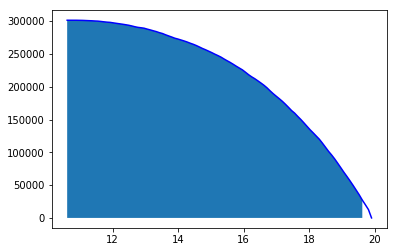

In [48]:
values, bins = np.histogram(b_energy_ar, bins =100 )
cumulative = np.cumsum(values)

plt.plot(bins[:-1], len(b_energy_ar)-cumulative, c='blue')

#and fill the area containing 90% of electron energies
perc = np.percentile(b_energy_ar, 90)
indexmin = np.digitize(perc, bins)
minvalue = (len(b_energy_ar)-cumulative)[indexmin]
plt.fill_between(bins[:-1], 0, len(b_energy_ar)-cumulative, where = ((len(b_energy_ar)-cumulative)>minvalue))
plt.show()


This is the standard method of sampling in literature and as we'll see later it cannot be applied for the tranmission case. 

## ------------------------------Aside ends here----------------------------------